# Regression to predict Dengue Cases in Brazil

### We explored neural networks to do a regression task and try to predict the dengue spread in Brazil.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12345)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


### Let's load the data set

In [2]:
df = pd.read_csv("./Dados/Datasets/Belo Horizonte.csv.gz")

In [3]:
df

,capital,data_alvo,ocorrencias_alvo,por_habitante_alvo,municipio,dt_sintoma,lag,ocorrencias,por_habitante,distancia
0,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-01,157.0,24,3.772523,12.48
1,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-08,156.0,40,6.286037,12.48
2,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-15,155.0,21,3.299381,12.48
3,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-22,154.0,35,5.497664,12.48
4,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-29,153.0,31,4.868197,12.48
...,...,...,...,...,...,...,...,...,...,...
1106373,Belo Horizonte,2019-04-28,5683,225.203180,Vitória,2019-03-24,5.0,146,40.212963,3.78
1106374,Belo Horizonte,2019-04-28,5683,225.203180,Vitória,2019-03-31,4.0,204,56.176217,3.78
1106375,Belo Horizonte,2019-04-28,5683,225.203180,Vitória,2019-04-07,3.0,196,53.962083,3.78
1106376,Belo Horizonte,2019-04-28,5683,225.203180,Vitória,2019-04-14,2.0,180,49.546648,3.78


#### We are going to split the data into train and test data sets. The columns we'll use are: por_habitante_alvo, 'lag, por_habitante and distancia

In [4]:
train_data = df[['por_habitante_alvo','por_habitante','lag','distancia']]
train_data

,por_habitante_alvo,por_habitante,lag,distancia
0,46.279053,3.772523,157.0,12.48
1,46.279053,6.286037,156.0,12.48
2,46.279053,3.299381,155.0,12.48
3,46.279053,5.497664,154.0,12.48
4,46.279053,4.868197,153.0,12.48
...,...,...,...,...
1106373,225.203180,40.212963,5.0,3.78
1106374,225.203180,56.176217,4.0,3.78
1106375,225.203180,53.962083,3.0,3.78
1106376,225.203180,49.546648,2.0,3.78


In [5]:
train_dataset = train_data.sample(frac=0.8)
test_dataset = train_data.drop(train_dataset.index)
train_dataset.head()

,por_habitante_alvo,por_habitante,lag,distancia
612739,19.181732,4.953185,31.0,25.56
299690,3.247096,4.519876,22.0,24.77
429596,542.021636,5.513431,112.0,18.93
322720,4.055821,4.215090,71.0,31.17
1011058,5.682581,0.688661,21.0,14.39


### We are going to normalize the input.

In [6]:
train_stats = train_data.describe()
train_stats.pop('por_habitante_alvo')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
por_habitante,1106378.0,15.949661,41.611200,0.0,1.890014,4.716662,13.243189,711.541423
lag,1106378.0,79.000071,45.321057,1.0,40.000000,79.000000,118.000000,157.000000
distancia,1106378.0,14.451103,7.846408,0.0,8.200000,13.720000,19.320000,31.170000


In [7]:
train_labels = train_dataset.pop('por_habitante_alvo')
test_labels = test_dataset.pop('por_habitante_alvo')

In [8]:
train_labels.head()

612739      19.181732
299690       3.247096
429596     542.021636
322720       4.055821
1011058      5.682581
Name: por_habitante_alvo, dtype: float64

In [9]:
test_labels.head()

0     46.279053
2     46.279053
3     46.279053
13    46.279053
17    46.279053
Name: por_habitante_alvo, dtype: float64

In [10]:
#Given a dataset, normalize it.
def norm(x):
    return (x - (train_stats['mean'])) / (train_stats['std'])
            
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
normed_train_data.head()

,por_habitante,lag,distancia
612739,-0.264267,-1.059112,1.415794
299690,-0.274680,-1.257695,1.315111
429596,-0.250803,0.728137,0.570821
322720,-0.282005,-0.176520,2.130771
1011058,-0.366752,-1.279760,-0.007787


In [12]:
normed_test_data.head()

,por_habitante,lag,distancia
0,-0.292641,1.721053,-0.251211
2,-0.304011,1.676923,-0.251211
3,-0.251182,1.654858,-0.251211
13,-0.270324,1.434210,-0.251211
17,-0.315579,1.345951,-0.251211


## Let's build the model. We are going to use a neural Dense network with 1 hidden layer.

In [13]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]), 
    layers.Dense(64, activation=tf.nn.relu),     
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return(model)

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


## Let's have an example output

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.05770554],
       [ 0.08139139],
       [ 0.02089321],
       [ 0.13539147],
       [ 0.07058401],
       [ 0.04358768],
       [ 0.08727962],
       [ 0.07945891],
       [-0.00181973],
       [ 0.0185976 ]], dtype=float32)

## We are going to train the model with an early stopping function, to avoid overfitting.

In [18]:
EPOCHS = 40
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2,
  callbacks=[early_stop])


Train on 708081 samples, validate on 177021 samples
Epoch 1/40
708081/708081 [==============================] - 55s 78us/sample - loss: 12002.0062 - mean_absolute_error: 59.7634 - mean_squared_error: 12002.0195 - val_loss: 12199.0043 - val_mean_absolute_error: 59.6586 - val_mean_squared_error: 12199.0107
Epoch 2/40
708081/708081 [==============================] - 55s 78us/sample - loss: 11962.5968 - mean_absolute_error: 59.9057 - mean_squared_error: 11962.6387 - val_loss: 12179.3137 - val_mean_absolute_error: 59.2143 - val_mean_squared_error: 12179.3232
Epoch 3/40
708081/708081 [==============================] - 55s 77us/sample - loss: 11954.0751 - mean_absolute_error: 59.8910 - mean_squared_error: 11954.0771 - val_loss: 12157.1300 - val_mean_absolute_error: 60.6406 - val_mean_squared_error: 12157.1328
Epoch 4/40
708081/708081 [==============================] - 55s 78us/sample - loss: 11947.1929 - mean_absolute_error: 59.8489 - mean_squared_error: 11947.1846 - val_loss: 12176.7883 - va

#### For some reason, the loss functions achieved extremely high values and did not improve with the batches. This is probably a regression model is not adequate for this situation, and also de data set has several repeated values.

## Plotting the results, we obtain

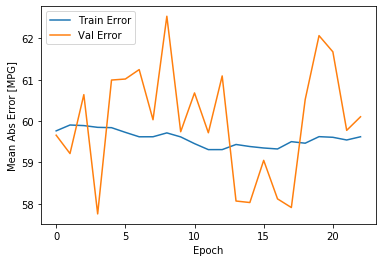

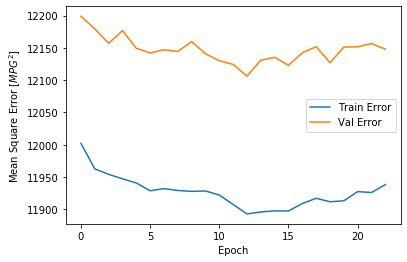

In [19]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    #plt.ylim([0.4,0.6])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0.9,1.1])
    plt.legend()
    plt.show()


plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} por_habitante".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} por_habitante".format(mse))

Testing set Mean Abs Error: 59.91 por_habitante
Testing set Mean Sqr Error: 12061.12 por_habitante


(0, 688.3842895331757)

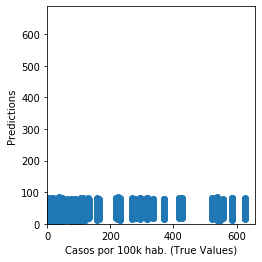

In [52]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Casos por 100k hab. (True Values)')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([25, 90], [40, 230])